In [299]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import scipy as sci
from scipy import integrate
from scipy.integrate import solve_ivp
from astropy import units as u
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import astropy.constants as const
import math
import pickle
from scipy.special import erf

In [300]:
plt.rcParams['font.family'] = 'Times New Roman'

In [301]:
a_0 = 2.95 
b_0 = 0.596
mstar_tot = 1e11 * u.Msun
r_eff = (a_0*(mstar_tot/(1.e6*u.Msun))**b_0)* u.pc

print(r_eff)

# %%
m1 = 4e8 * u.Msun

rb = (m1/mstar_tot)**(1./3.)*r_eff
print("Binary radius is:", rb)
dyn_hard = (((rb/r_eff)**3)*r_eff).to(u.pc)
print(dyn_hard)


2817.2281287632354 pc
Binary radius is: 447.20708952331626 pc
11.268912515052946 pc


In [302]:
G = const.G.to(u.pc**3/(u.kg*u.yr**2))
print(G) #change the innate time to years
m_gal = 1e11 * const.M_sun
#Masses
m1=4e8 * const.M_sun #mass of black hole A
m2=4e8 * const.M_sun #mass of black hole B


sep = 430*u.pc
r1_initial=[((sep/2.).value),0,0] * u.pc
r2_initial=[-((sep/2.).value),0,0] * u.pc
#To arrays

r1=np.array(r1_initial,dtype="float64") * u.pc
r2=np.array(r2_initial,dtype="float64") * u.pc

#Semi-major axis
a = (0.5 * (sep))

#COM
r_com=(m1*r1+m2*r2)/(m1+m2)

#orbital veloctiy
# orb_v = (np.sqrt(const.G*(m1+m2)/a)).to(u.km/u.s) #added with Kris' source
# v = np.sqrt((const.G * (m1)) / r.to(u.m)).to(u.km/u.s)
angle = 90
angle_rad = np.radians(angle)
v_circ = (np.sqrt((G*m1*(sep/2))/(sep)**2)).value
# v_circ = (126 * u.km/u.s).to(u.pc/u.yr).value

print(r1)
#V_i
# v1_initial1=[-np.cos(angle_rad) * v_circ, np.sin(angle_rad) * v_circ, 0] *u.pc/u.yr
# v2_inital1=[np.cos(angle_rad) * v_circ,-np.sin(angle_rad) * v_circ,0] *u.pc/u.yr #km/s
v1_initial1=[0, v_circ, 0] *u.pc/u.yr
v2_inital1=[0, -v_circ, 0] *u.pc/u.yr #km/s
#change as needed to test
# v_df_fixed = (126 * u.km/u.s).to(u.pc/u.yr)
v_df_fixed = (np.sqrt((G*m1*(sep/2))/(sep)**2))
# v_df_fixed = ((90 * (np.sqrt(2)/2)) * u.km/u.s).to(u.pc/u.yr)
v1_df = np.array([-np.cos(angle_rad) * v_df_fixed.value, np.sin(angle_rad) * v_df_fixed.value, 0])
v2_df = np.array([np.cos(angle_rad) * v_df_fixed.value, -np.sin(angle_rad) * v_df_fixed.value, 0])

#To arrays
v1=np.array(v1_initial1,dtype="float64") *u.pc/u.yr
v2=np.array(v2_inital1,dtype="float64") *u.pc/u.yr
#Find velocity of COM
v_com=(m1*v1+m2*v2)/(m1+m2)

print(v1_df)
print((v_circ * u.pc / u.yr).to(u.km /u.s))

2.2623616075142032e-45 pc3 / (kg yr2)
[215.   0.   0.] pc
[-2.80088703e-21  4.57419565e-05  0.00000000e+00]
44.72612924484049 km / s


In [303]:
def velocity_dispersion(m_gal_):
    '''This is the velocity dispersion of the galaxy.
    Calculated at km/s and then converted to pc/yr for solver
    m_gal_ = 1e11 * M_sun - in kg'''
    
    o = ((10**(2.2969) * ((m_gal_ * u.kg) / (10**(11) * const.M_sun))**(0.299)) * (u.km/u.s)).to(u.pc / u.yr)
    return o.value  # as float (in pc/yr) for faster solving


def coulomb_logarithm(r_com_, o_, G_val, m_val):
    """Calculate Coulomb logarithm, no units in this either
    r_com = distance of each body to the com (which is at [0,0,0] hence unchanging
    o_ = vel dispersion
    G_val = taking val of G to be unitless (remember that we have converted the constant to respective pc/yr requirement
    m_val = in kg ))"""
    
    x = (r_com_ * (o_**2)) / (G_val * m_val)
    return math.log10(x)


def dynamical_friction_a(r_com_, v_rel_, ln_A_, G_val, m_val):
    """Return dynamical friction force, kg * pc / yr^2
    Edits : made some changes such as directly adding in the vectors so that there is no confusion that it is not opposite to the velcoity
    v_rel = should be v_1 - v_com
    v_mag = magnitude of that (to get direction in vectorized form)
    F_D_force = simplified chandrasekhar formula
    then we add vector directions and make it opposite
    and hten make it an arr so that DIRECTION is emphasized lol - add units so that conversion is neat
    and then a_df_mag (just so other units dont get confused when called again in the last function)
    """
    v_mag = np.linalg.norm(v_rel_)
    unit_v = v_rel_ / v_mag
    F_D_force = 0.428 * ln_A_ * ((G_val * m_val**2) / r_com_**2)  # it should be confirmed here that though it is unitless the numbers are correct

    F_D_i = -1 * (F_D_force * unit_v[0])  # ensure opposite direction
    F_D_j = -1 * (F_D_force * unit_v[1])
    F_D_k = -1 * (F_D_force * unit_v[2])

    DF_forcearr = np.array([F_D_i, F_D_j, F_D_k]) * ((u.kg * u.pc) / (u.yr**2))
    a_df_mag = (DF_forcearr / (m_val * u.kg)).to(u.pc / (u.yr**2)).value

    return a_df_mag


def calculate_DF(G_val, m1_val, m2_val, m_gal_val, r1_pc, r2_pc, v1_pcyr, v2_pcyr):  
    # added units to variables so confusion is less
    """Calculate dynamical friction for both bodies
    apply everything and just to make clear there are no units. Most have been .value so that the solver only clauclates floats - maybe that is main source of error
    but the other way takes too much time for more timesteps- ensured that units are correct as far as I know"""
    
    r_com = (m1_val*r1_pc + m2_val*r2_pc) / (m1_val + m2_val)  # should be 0 and is 0 for first time step - will recheck this later 
    v_com = (m1_val*v1_pcyr + m2_val*v2_pcyr) / (m1_val + m2_val)  # same here

    o_pcyr = velocity_dispersion(m_gal_val)  # pc/yr

    r1_com_pc = np.linalg.norm(r1_pc - r_com)  # pc
    r2_com_pc = np.linalg.norm(r2_pc - r_com)  # pc
    v1_rel_pcyr = v1_pcyr - v_com  # pc / yr
    v2_rel_pcyr = v2_pcyr - v_com  # pc / yr

    ln_A1 = coulomb_logarithm(r1_com_pc, o_pcyr, G_val, m1_val)  # no units
    ln_A2 = coulomb_logarithm(r2_com_pc, o_pcyr, G_val, m2_val)  # no units

    a_df1 = dynamical_friction_a(r1_com_pc, v1_rel_pcyr, ln_A1, G_val, m1_val)  # pc/yr**2
    a_df2 = dynamical_friction_a(r2_com_pc, v2_rel_pcyr, ln_A2, G_val, m2_val)  # pc/yr^2

    return a_df1, a_df2

In [304]:
def dydt(t, y, m1, m2, G, m_gal, df_on=False):
        '''
        This is the function for the solve_ivp - same structure like odeint but htere is freedom of choosing hte methods based on what you are solving
        AREAS OF DOUBT: (aka questions to ask when rechecking #3)
        - do i have to rename the r1,r2,v1,v2 since what if they are taken in as global variables and this means that the positon and velocity is not really changing (idk how to check this)
        - is the a1_grav that is being slowed down affect the vel and the position? as in:

        a1_total in index 0 then integrate to find position and vel for next time step? really need to think about the process in which the solver takes in teh values and calculates the next timestep
        '''

        r1 = y[0:3]
        r2 = y[3:6]
        v1 = y[6:9]
        v2 = y[9:12]

        r12 = r2 - r1
        r12_mag = np.linalg.norm(r12)
        a1_grav = (G * m2 / r12_mag**3) * r12
        a2_grav = (G * m1 / r12_mag**3) * (-r12)

        a1_df = np.zeros(3)
        a2_df = np.zeros(3)
        if df_on:
            a1_df, a2_df = calculate_DF(G, m1, m2, m_gal, r1, r2, v1, v2)

        a1_total = a1_grav + (1 * a1_df)
        a2_total = a2_grav + (1 * a2_df)

        return np.concatenate([v1, v2, a1_total, a2_total])

In [305]:
orbital_period = np.sqrt((4 * (np.pi)**2 / (G * (m1)) * (a**3))).to(u.Myr)

print(orbital_period)
(20 * u.Myr).to(u.s)

14.766364899677814 Myr


<Quantity 6.31152e+14 s>

In [306]:
# # def dydt(t, y, m1, m2, G, m_gal, sigma, df_on=False):
# #     """
# #     Time derivative function for solve_ivp.
# #     y: state vector [r1(3), r2(3), v1(3), v2(3)] in pc and pc/yr
# #     m1, m2: BH masses in kg
# #     G: gravitational constant in pc^3/(kg*yr^2)
# #     m_gal: galaxy mass in kg
# #     sigma: velocity dispersion in pc/yr (precomputed)
# #     df_on: toggle for dynamical friction
# #     """
# #     # Unpack positions and velocities
# #     r1 = y[0:3]
# #     r2 = y[3:6]
# #     v1 = y[6:9]
# #     v2 = y[9:12]

# #     # Relative position and distance
# #     r12 = r2 - r1
# #     r12_mag = np.linalg.norm(r12)

# #     # Gravitational accelerations
# #     a1_grav = (G * m2 / r12_mag**3) * r12
# #     a2_grav = (G * m1 / r12_mag**3) * (-r12)

# #     # Dynamical friction accelerations
# #     a1_df = np.zeros(3)
# #     a2_df = np.zeros(3)
# #     if df_on:
# #         a1_df, a2_df = calculate_DF(G, m1, m2, m_gal, r1, r2, v1, v2)

# #     # Total accelerations
# #     a1_total = a1_grav + a1_df
# #     a2_total = a2_grav + a2_df

# #     # Return derivative of state vector: [dr1/dt, dr2/dt, dv1/dt, dv2/dt]
# #     return np.concatenate([v1, v2, a1_total, a2_total])


# def dydt(t, y, m1, m2, G, m_gal, sigma, df_on=False, full_df=True):
#     r1 = y[0:3]
#     r2 = y[3:6]
#     v1 = y[6:9]
#     v2 = y[9:12]

#     r12 = r2 - r1
#     r12_mag = np.linalg.norm(r12)

#     # Gravity
#     a1_grav = (G * m2 / r12_mag**3) * r12
#     a2_grav = (G * m1 / r12_mag**3) * (-r12)

#     # Dynamical friction
#     a1_df = np.zeros(3)
#     a2_df = np.zeros(3)
#     if df_on:
#         a1_df, a2_df = calculate_DF(G, m1, m2, m_gal, r1, r2, v1, v2, sigma, full=full_df)

#     # Total acceleration
#     a1_total = a1_grav + a1_df
#     a2_total = a2_grav + a2_df

#     return np.concatenate([v1, v2, a1_total, a2_total])

In [307]:
t_i = 0.0  # yr
t_f = (11.9* u.Myr).to(u.yr).value  # in yr
t_eval = np.linspace(t_i, t_f, 400) #linspace so 400 timesteps only

G_val = G.value  # in pc^3 / (kg * yr^2)
m1_val = m1.to(u.kg).value
m2_val = m2.to(u.kg).value
m_gal_val = m_gal.value

In [308]:
((20 * u.Myr)/50000).to(u.yr)

<Quantity 400. yr>

In [309]:
y01 = np.concatenate([
    r1.to_value(u.pc),
    r2.to_value(u.pc),
    v1.to_value(u.pc/u.yr),
    v2.to_value(u.pc/u.yr) #.value intake
])

y0_df = np.concatenate([
    r1.to_value(u.pc),
    r2.to_value(u.pc), #.value intake
    v1_df,
    v2_df
])

print("Solving without DF...")

sol_no_df = solve_ivp(
    fun=lambda t, y: dydt(t, y, m1_val, m2_val, G_val, m_gal_val, df_on=False),
    t_span=(t_i, t_f),
    y0=y01,
    t_eval=t_eval,
    method='DOP853',
    rtol=1e-8,
    atol=1e-8
)

print("Solving with DF...")
sol_df = solve_ivp(
    fun=lambda t, y: dydt(t, y, m1_val, m2_val, G_val, m_gal_val, df_on=True),
    t_span=(t_i, t_f),
    y0=y0_df,
    t_eval=t_eval,
    method='DOP853',
    rtol=1e-8,
    atol=1e-8
)

Solving without DF...
Solving with DF...


In [310]:
def unpack_solution(sol):
    r1_ = sol.y[0:3].T  # shape (N, 3)
    r2_ = sol.y[3:6].T
    v1_ = sol.y[6:9].T
    v2_ = sol.y[9:12].T
    sep = np.linalg.norm(r1_ - r2_, axis=1)
    return r1_, r2_, v1_, v2_, sep

r1_nodf_arr, r2_nodf_arr, v1_nodf_arr, v2_nodf_arr, sep_nodf_arr = unpack_solution(sol_no_df)
r1_df_arr, r2_df_arr, v1_df_arr, v2_df_arr, sep_df_arr = unpack_solution(sol_df)


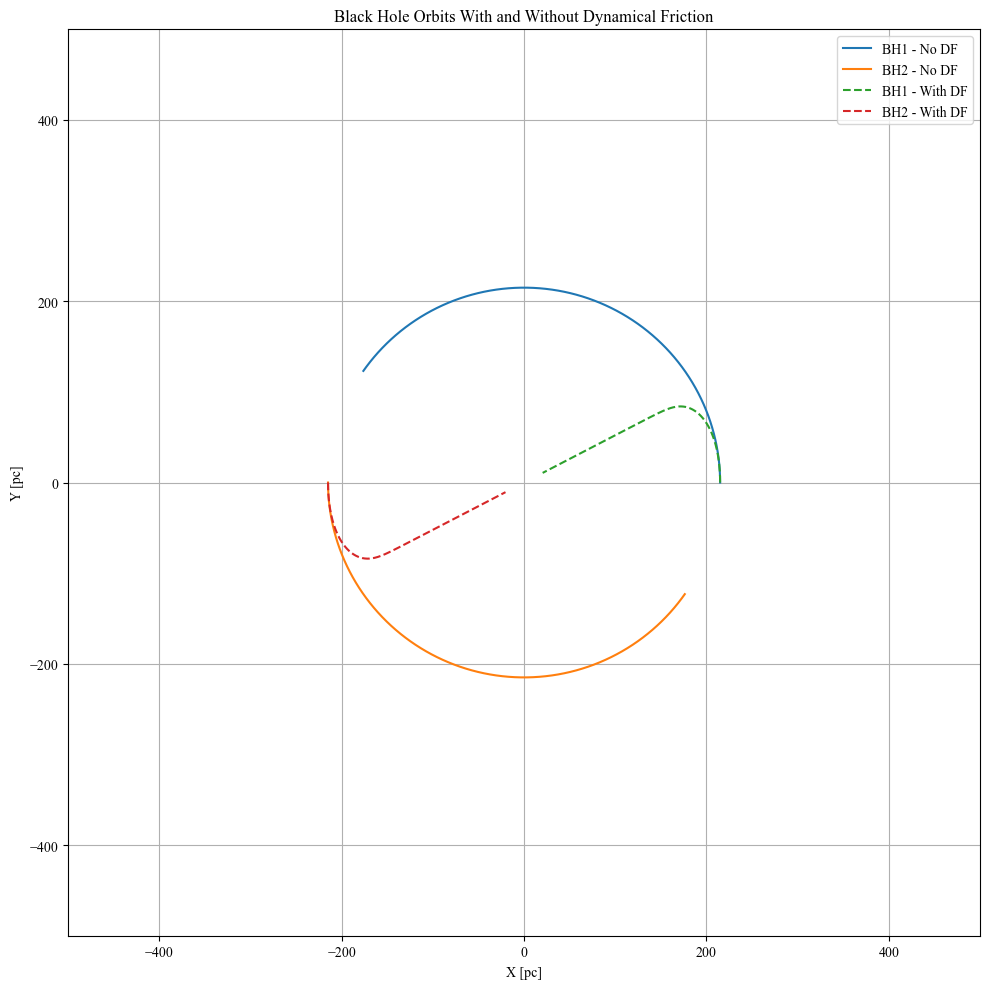

In [311]:
plt.figure(figsize=(10, 10))
plt.plot(r1_nodf_arr[:, 0], r1_nodf_arr[:, 1], label='BH1 - No DF')
plt.plot(r2_nodf_arr[:, 0], r2_nodf_arr[:, 1], label='BH2 - No DF')
plt.plot(r1_df_arr[:, 0], r1_df_arr[:, 1], label='BH1 - With DF', linestyle='--')
plt.plot(r2_df_arr[:, 0], r2_df_arr[:, 1], label='BH2 - With DF', linestyle='--')
plt.xlabel('X [pc]')
plt.ylabel('Y [pc]')
plt.xlim(-500, 500)
plt.ylim(-500, 500)
plt.title('Black Hole Orbits With and Without Dynamical Friction')
plt.legend()
plt.grid(True)
# plt.ylim(-230, 230)
# plt.xlim(-230,230)
plt.tight_layout()

# initial_conditions_text = (
#     f"Initial Conditions:\n"
#     f"BH A: Position: {r1_initial}, Velocity: {v1_df}\n"
#     f"BH B: Position: {r2_initial}, Velocity: {v2_df}\n"
#     f"Time: 0 to {t_f}"
# )
# plt.text(0.0, 0.5, initial_conditions_text, fontsize= 8, bbox=dict(boxstyle="round", facecolor="lightgray", alpha=0.9))
plt.show()

In [312]:
def compute_forces(G_, m1, m2, m_gal_, r1_arr, r2_arr, v1_arr, v2_arr, df_on=False):
        N = r1_arr.shape[0]
        a_grav1 = np.zeros((N, 3))
        a_grav2 = np.zeros((N, 3))
        a_df1 = np.zeros((N, 3))
        a_df2 = np.zeros((N, 3))
        a_total1 = np.zeros((N, 3))
        a_total2 = np.zeros((N, 3))

        for i in range(N):
            r1_ = r1_arr[i]
            r2_ = r2_arr[i]
            v1_ = v1_arr[i]
            v2_ = v2_arr[i]

            r12 = r2_ - r1_
            r12_mag = np.linalg.norm(r12)


            a1_grav = (G_ * m2 / r12_mag**3) * r12
            a2_grav = (G_ * m1 / r12_mag**3) * (-r12)


            a1_df = np.zeros(3)
            a2_df = np.zeros(3)
            if df_on:
                a1_df, a2_df = calculate_DF(G_, m1, m2, m_gal_, r1_, r2_, v1_, v2_)

            a_grav1[i] = a1_grav
            a_grav2[i] = a2_grav
            a_df1[i] = a1_df
            a_df2[i] = a2_df


            a_total1[i] = a1_grav + a1_df
            a_total2[i] = a2_grav + a2_df

        return a_grav1, a_grav2, a_df1, a_df2, a_total1, a_total2



a_grav1_nodf, a_grav2_nodf, a_df1_nodf, a_df2_nodf, a_tot1_nodf, a_tot2_nodf = compute_forces(
    G_val, m1_val, m2_val, m_gal_val,
    r1_nodf_arr, r2_nodf_arr, v1_nodf_arr, v2_nodf_arr, df_on=False
)


a_grav1_df, a_grav2_df, a_df1_df, a_df2_df, a_tot1_df, a_tot2_df = compute_forces(
    G_val, m1_val, m2_val, m_gal_val,
    r1_df_arr, r2_df_arr, v1_df_arr, v2_df_arr, df_on=True
)


In [313]:
speed1_nodf = np.linalg.norm(v1_nodf_arr, axis=1) * u.pc/u.yr
speed1_df = np.linalg.norm(v1_df_arr, axis=1) * u.pc/u.yr

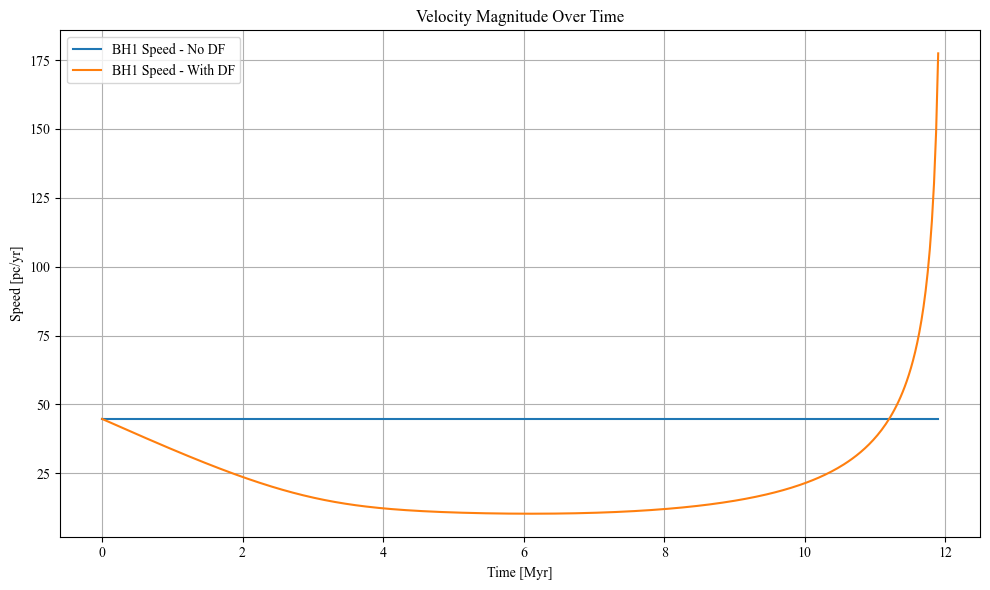

In [314]:
plt.figure(figsize=(10, 6))
plt.plot(t_eval[:len(speed1_nodf)] / 1e6, (speed1_nodf.to(u.km /u.s)), label='BH1 Speed - No DF') #same with this
plt.plot(t_eval[:len(speed1_df)] / 1e6, (speed1_df.to(u.km /u.s)), label='BH1 Speed - With DF')
plt.xlabel('Time [Myr]')
plt.ylabel('Speed [pc/yr]')
plt.title('Velocity Magnitude Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

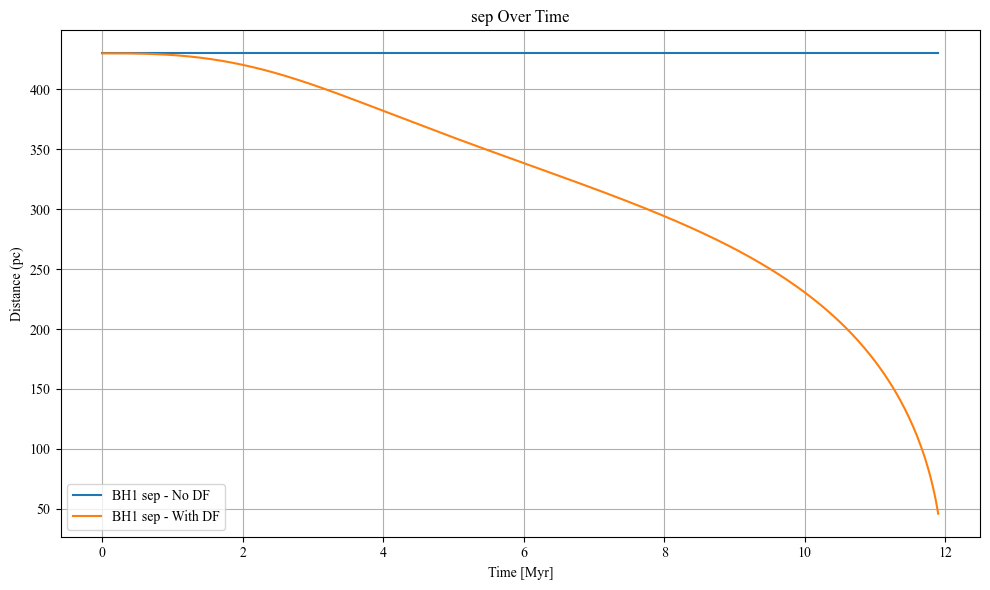

In [315]:
plt.figure(figsize=(10, 6))
plt.plot(t_eval[:len(sep_nodf_arr)] / 1e6, sep_nodf_arr, label='BH1 sep - No DF') #same with this
plt.plot(t_eval[:len(sep_df_arr)] / 1e6, sep_df_arr, label='BH1 sep - With DF')
plt.xlabel('Time [Myr]')
plt.ylabel('Distance (pc)')
plt.title('sep Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

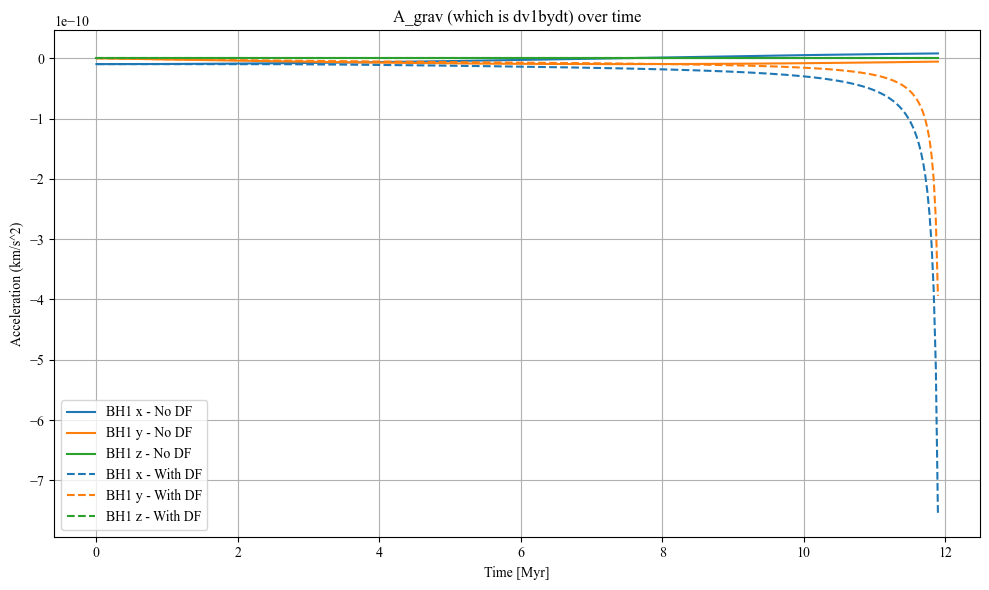

In [316]:
plt.figure(figsize=(10, 6))

# copilot helped with this
colors = ['tab:blue', 'tab:orange', 'tab:green']


plt.plot(t_eval[:len(a_grav1_nodf)] / 1e6, a_grav1_nodf[:, 0], color=colors[0], linestyle='-', label='BH1 x - No DF')
plt.plot(t_eval[:len(a_grav1_nodf)] / 1e6, a_grav1_nodf[:, 1], color=colors[1], linestyle='-', label='BH1 y - No DF')
plt.plot(t_eval[:len(a_grav1_nodf)] / 1e6, a_grav1_nodf[:, 2], color=colors[2], linestyle='-', label='BH1 z - No DF')


plt.plot(t_eval[:len(a_grav1_df)] / 1e6, a_grav1_df[:, 0], color=colors[0], linestyle='--', label='BH1 x - With DF')
plt.plot(t_eval[:len(a_grav1_df)] / 1e6, a_grav1_df[:, 1], color=colors[1], linestyle='--', label='BH1 y - With DF')
plt.plot(t_eval[:len(a_grav1_df)] / 1e6, a_grav1_df[:, 2], color=colors[2], linestyle='--', label='BH1 z - With DF')

plt.xlabel('Time [Myr]')
plt.ylabel('Acceleration (km/s^2)')
plt.title('A_grav (which is dv1bydt) over time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [317]:
v1_nodf = ((v1_nodf_arr * u.pc / u.yr).to(u.km / u.s)).value
v2_nodf = ((v2_nodf_arr * u.pc / u.yr).to(u.km / u.s)).value
a_grav1_nodf_arr = ((a_grav1_nodf * u.pc / u.yr**2).to(u.km / u.s**2)).value
a_grav2_nodf_arr = ((a_grav2_nodf * u.pc / u.yr**2).to(u.km / u.s**2)).value
a_df1_nodf_arr = ((a_df1_nodf * u.pc / u.yr**2).to(u.km / u.s**2)).value
a_df2_nodf_arr = ((a_df2_nodf * u.pc / u.yr**2).to(u.km / u.s**2)).value
a_tot1_nodf_arr = ((a_tot1_nodf * u.pc / u.yr**2).to(u.km / u.s**2)).value
a_tot2_nodf_arr = ((a_tot2_nodf * u.pc / u.yr**2).to(u.km / u.s**2)).value

v1_df = ((v1_df_arr * u.pc / u.yr).to(u.km / u.s)).value
v2_df = ((v2_df_arr * u.pc / u.yr).to(u.km / u.s)).value
a_grav1_df_arr = ((a_grav1_df * u.pc / u.yr**2).to(u.km / u.s**2)).value
a_grav2_df_arr = ((a_grav2_df * u.pc / u.yr**2).to(u.km / u.s**2)).value
a_df1_df_arr = ((a_df1_df * u.pc / u.yr**2).to(u.km / u.s**2)).value
a_df2_df_arr = ((a_df2_df * u.pc / u.yr**2).to(u.km / u.s**2)).value
a_tot1_df_arr = ((a_tot1_df * u.pc / u.yr**2).to(u.km / u.s**2)).value
a_tot2_df_arr = ((a_tot2_df * u.pc / u.yr**2).to(u.km / u.s**2)).value


In [318]:
data_dict_nodf = {
    "r1": r1_nodf_arr,          
    "r2": r2_nodf_arr,          
    "v1": v1_nodf,          
    "v2": v2_nodf,          
    "sep": sep_nodf_arr,        
    "a_grav1": a_grav1_nodf_arr,    
    "a_grav2": a_grav2_nodf_arr,    
    "a_df1": a_df1_nodf_arr,        
    "a_df2": a_df2_nodf_arr,        
    "a_total1": a_tot1_nodf_arr,    
    "a_total2": a_tot2_nodf_arr,    
    "t": t_eval                 
}


data_dict_df = {
    "r1": r1_df_arr,
    "r2": r2_df_arr,
    "v1": v1_df,
    "v2": v2_df,
    "sep": sep_df_arr,
    "a_grav1": a_grav1_df_arr,
    "a_grav2": a_grav2_df_arr,
    "a_df1": a_df1_df_arr,
    "a_df2": a_df2_df_arr,
    "a_total1": a_tot1_df_arr,
    "a_total2": a_tot2_df_arr,
    "t": t_eval
}

In [319]:
with open("data_dict_nodf.pkl", "wb") as f:
    pickle.dump(data_dict_nodf, f)

with open("data_dict_df.pkl", "wb") as f:
    pickle.dump(data_dict_df, f)

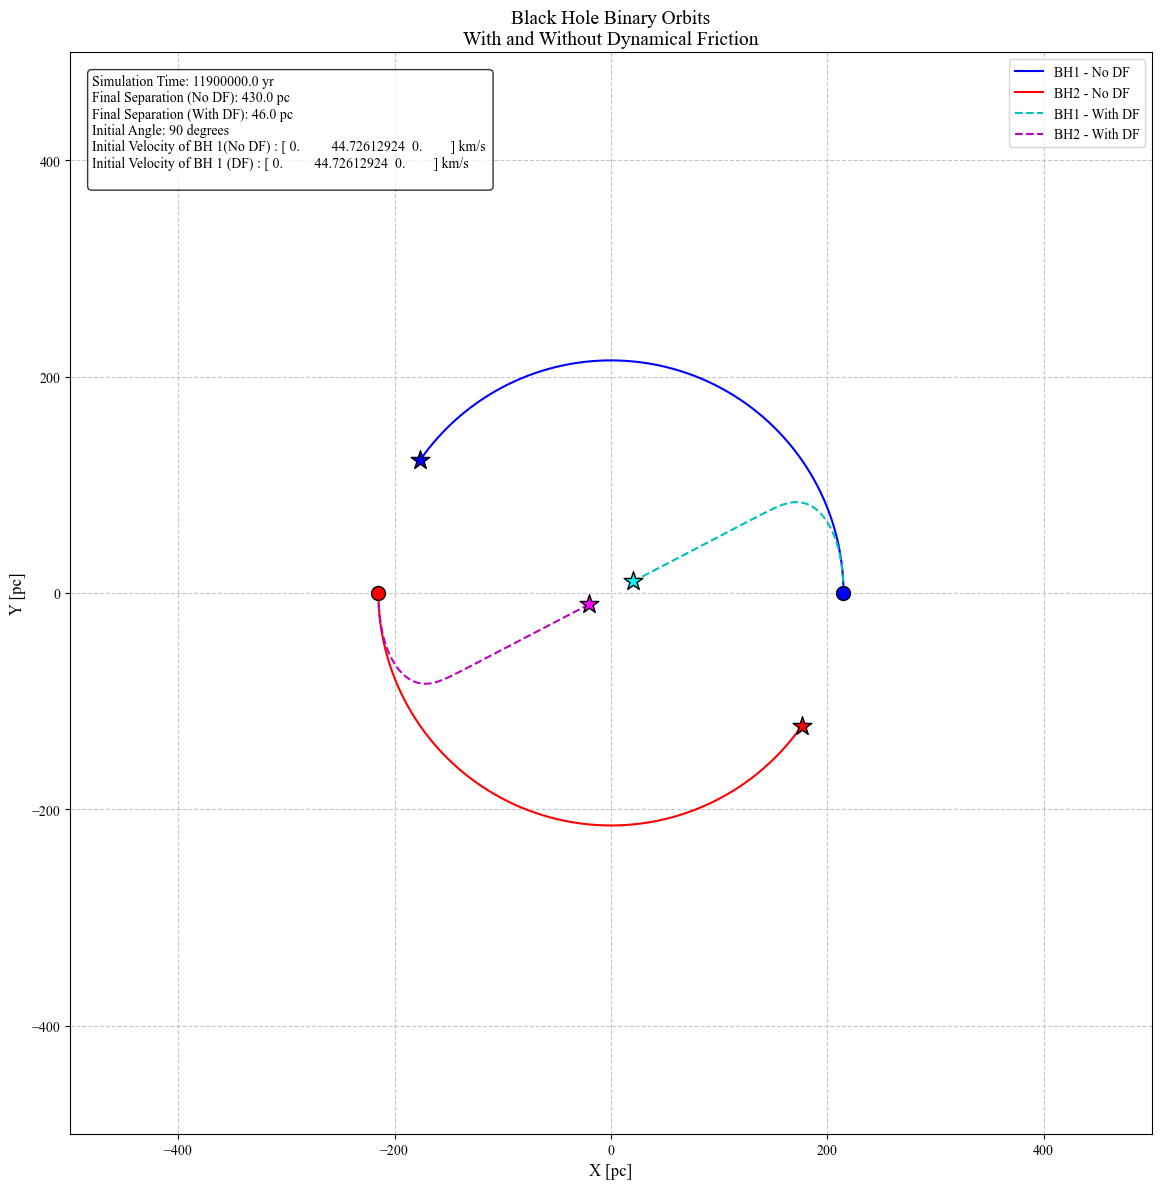

In [350]:
plt.figure(figsize=(12, 12))
    

r1_nodf = data_dict_nodf['r1']
r2_nodf = data_dict_nodf['r2']
r1_df = data_dict_df['r1']
r2_df = data_dict_df['r2']
    

plt.plot(r1_nodf[:, 0], r1_nodf[:, 1], 'b-', label='BH1 - No DF', linewidth=1.5)
plt.plot(r2_nodf[:, 0], r2_nodf[:, 1], 'r-', label='BH2 - No DF', linewidth=1.5)
plt.plot(r1_df_arr[:, 0], r1_df_arr[:, 1], 'c--', label='BH1 - With DF', linewidth=1.5)
plt.plot(r2_df_arr[:, 0], r2_df_arr[:, 1], 'm--', label='BH2 - With DF', linewidth=1.5)
    
    # Start
plt.scatter(r1_nodf[0, 0], r1_nodf[0, 1], c='blue', marker='o', s=100, edgecolor='black', zorder=5)
plt.scatter(r2_nodf[0, 0], r2_nodf[0, 1], c='red', marker='o', s=100, edgecolor='black', zorder=5)
    
    # End
plt.scatter(r1_nodf[-1, 0], r1_nodf[-1, 1], c='blue', marker='*', s=200, edgecolor='black', zorder=5)
plt.scatter(r2_nodf[-1, 0], r2_nodf[-1, 1], c='red', marker='*', s=200, edgecolor='black', zorder=5)
plt.scatter(r1_df[-1, 0], r1_df[-1, 1], c='cyan', marker='*', s=200, edgecolor='black', zorder=5)
plt.scatter(r2_df[-1, 0], r2_df[-1, 1], c='magenta', marker='*', s=200, edgecolor='black', zorder=5)
    
plt.xlabel('X [pc]', fontsize=12)
plt.xlim(-500, 500)
plt.ylim(-500, 500)
plt.ylabel('Y [pc]', fontsize=12)
plt.title('Black Hole Binary Orbits\nWith and Without Dynamical Friction', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10, loc='upper right')
plt.gca().set_aspect('equal', adjustable='box')
    
text_str = (
    f"Simulation Time: {data_dict_nodf['t'][-1]:.1f} yr\n"
    f"Final Separation (No DF): {np.linalg.norm(data_dict_nodf['r1'][-1]-data_dict_nodf['r2'][-1]):.1f} pc\n"
    f"Final Separation (With DF): {np.linalg.norm(data_dict_df['r1'][-1]-data_dict_df['r2'][-1]):.1f} pc\n"
    f"Initial Angle: {angle} degrees\n"
    f"Initial Velocity of BH 1(No DF) : {data_dict_nodf['v1'][0]} km/s \n"
    f"Initial Velocity of BH 1 (DF) : {data_dict_nodf['v1'][0]} km/s \n"
    )
plt.text(0.02, 0.98, text_str, transform=plt.gca().transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    

    
plt.tight_layout()
plt.show()

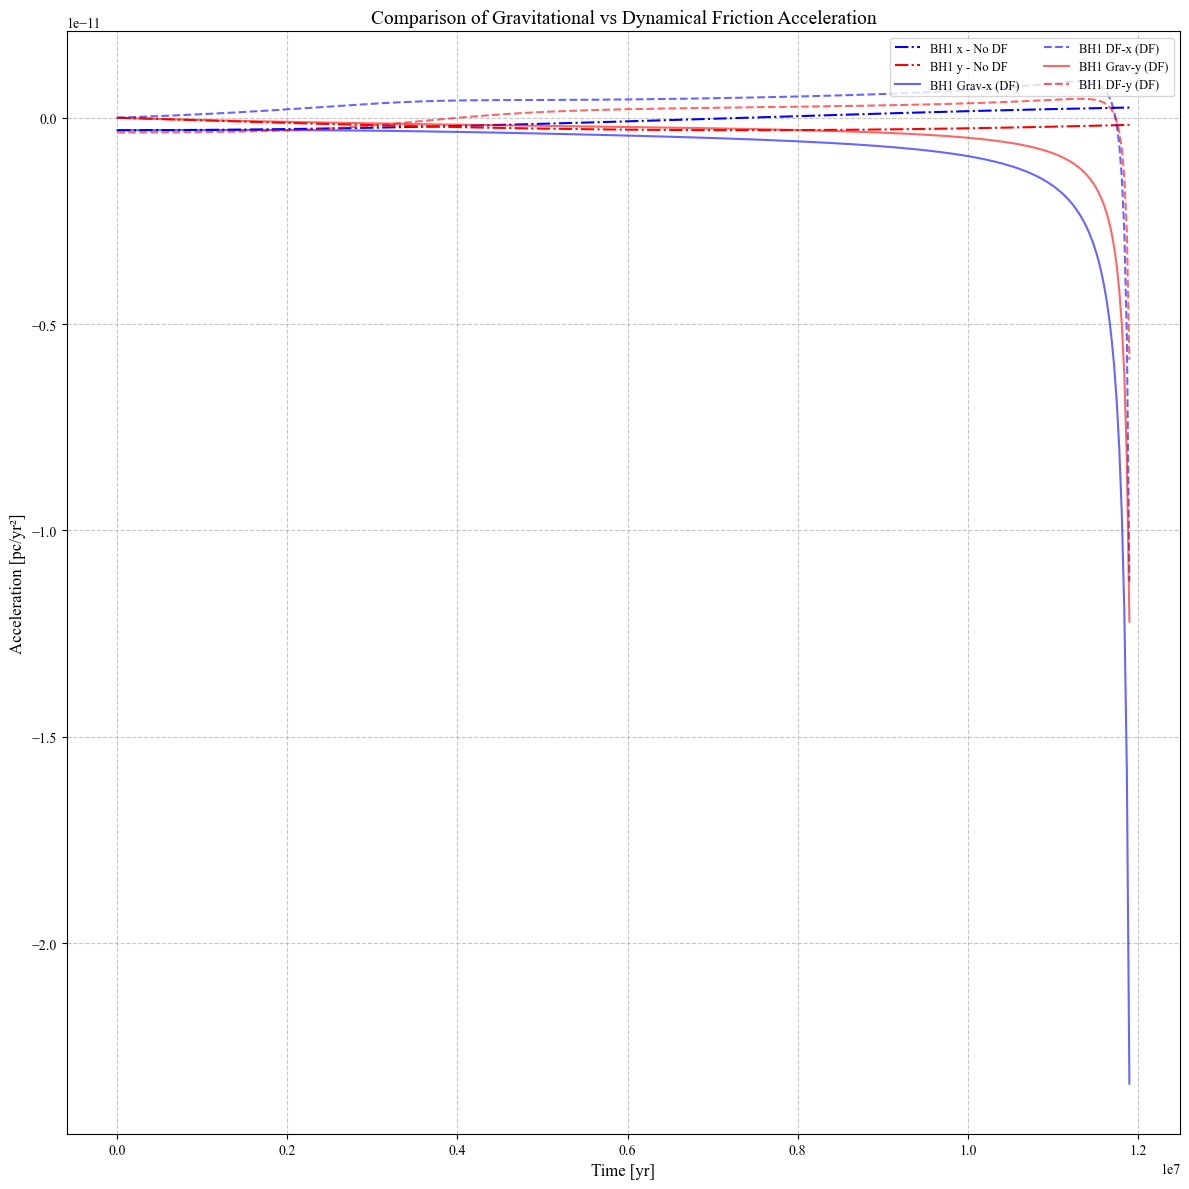

In [ ]:
plt.figure(figsize=(12, 12))

# Pull arrays from dicts
t = data_dict_nodf['t']   # both dicts share t_eval


a_grav1_df = data_dict_df['a_grav1']
a_grav1_nodf = data_dict_nodf['a_grav1']
a_grav2_df = data_dict_df['a_grav2']
a_df1_df   = data_dict_df['a_df1']
a_df2_df   = data_dict_df['a_df2']

# Colors for components
colors = {'x': 'b', 'y': 'r'}

# ---- BH1 (No DF vs With DF) ----
plt.plot(t , a_grav1_nodf[:, 0], color=colors['x'], linestyle='-.', label='BH1 x - No DF')
plt.plot(t, a_grav1_nodf[:, 1], color=colors['y'], linestyle='-.', label='BH1 y - No DF')
plt.plot(t, a_grav1_df[:, 0],   color=colors['x'], linestyle='-',  alpha=0.6, label='BH1 Grav-x (DF)')
plt.plot(t, a_df1_df[:, 0],     color=colors['x'], linestyle='--', alpha=0.6, label='BH1 DF-x (DF)')


plt.plot(t, a_grav1_df[:, 1],   color=colors['y'], linestyle='-',  alpha=0.6, label='BH1 Grav-y (DF)')
plt.plot(t, a_df1_df[:, 1],     color=colors['y'], linestyle='--', alpha=0.6, label='BH1 DF-y (DF)')


# Formatting
plt.xlabel('Time [yr]', fontsize=12)
plt.ylabel('Acceleration [pc/yr²]', fontsize=12)
# plt.ylim(-4e-13,4e-13)
plt.title('Comparison of Gravitational vs Dynamical Friction Acceleration', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=9, loc='upper right', ncol=2)
plt.tight_layout()
plt.show()

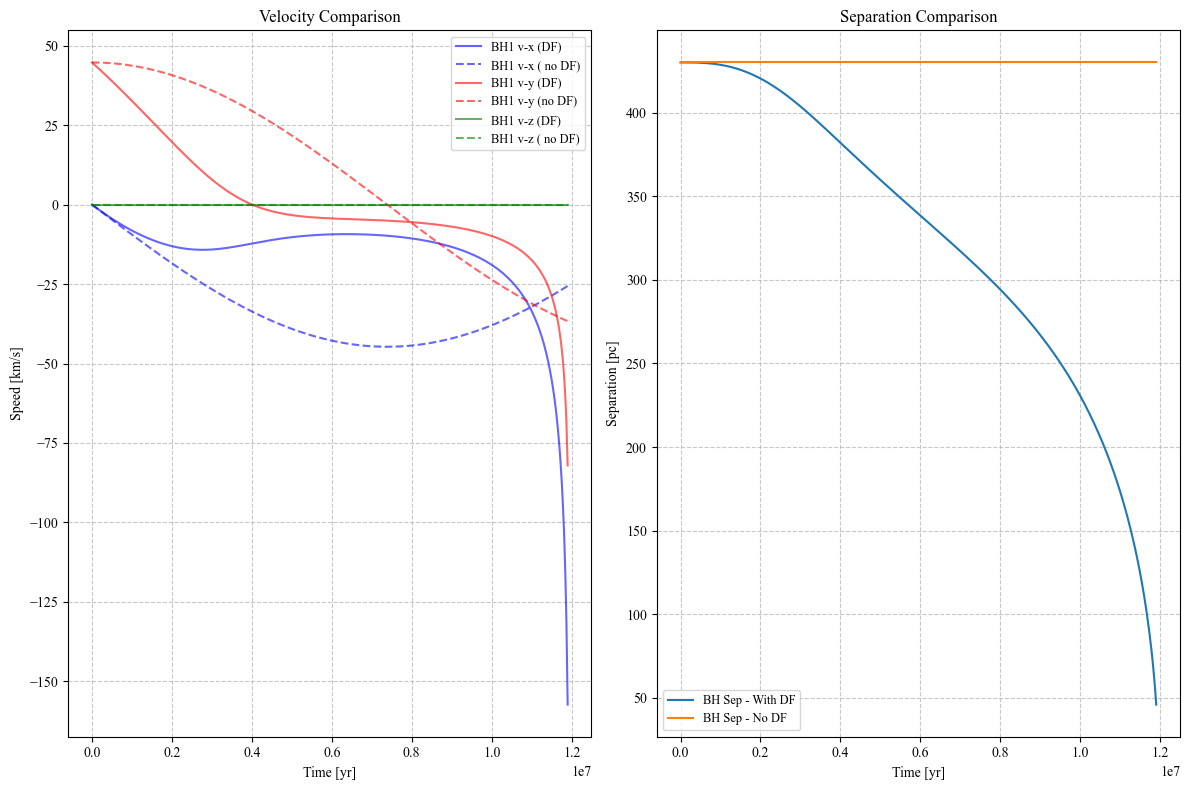

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 8))
t = data_dict_nodf['t']  


v1_df_dict   = data_dict_df['v1']
v1_nodf_dict = data_dict_nodf['v1']
sep_no_df    = data_dict_nodf['sep']
sep_df       = data_dict_df['sep']

colors = {'x': 'b', 'y': 'r', 'z': 'g'}

axs[0].plot(t, v1_df_dict[:, 0],   color=colors['x'], linestyle='-',  alpha=0.6, label='BH1 v-x (DF)')
axs[0].plot(t, v1_nodf_dict[:, 0],     color=colors['x'], linestyle='--', alpha=0.6, label='BH1 v-x ( no DF)')
axs[0].plot(t, v1_df_dict[:, 1],   color=colors['y'], linestyle='-',  alpha=0.6, label='BH1 v-y (DF)')
axs[0].plot(t, v1_nodf_dict[:, 1],     color=colors['y'], linestyle='--', alpha=0.6, label='BH1 v-y (no DF)')
axs[0].plot(t, v1_df_dict[:, 2],   color=colors['z'], linestyle='-',  alpha=0.6, label='BH1 v-z (DF)')
axs[0].plot(t, v1_nodf_dict[:, 2],     color=colors['z'], linestyle='--', alpha=0.6, label='BH1 v-z ( no DF)')
axs[0].set_xlabel('Time [yr]')
axs[0].set_ylabel('Speed [km/s]')
axs[0].set_title('Velocity Comparison')
axs[0].grid(True, linestyle='--', alpha=0.7)
axs[0].legend(fontsize=9)


axs[1].plot(t, sep_df,   label='BH Sep - With DF')
axs[1].plot(t, sep_no_df, label='BH Sep - No DF')
axs[1].set_xlabel('Time [yr]')
axs[1].set_ylabel('Separation [pc]')
axs[1].set_title('Separation Comparison')
axs[1].grid(True, linestyle='--', alpha=0.7)
axs[1].legend(fontsize=9)


plt.tight_layout()
plt.show()

In [ ]:
# with open("functionsspeed6.pkl", "wb") as f:
#     pickle.dump(data_dict_nodf, f)

# with open("functionsspeed6_df.pkl", "wb") as f:
#     pickle.dump(data_dict_df, f)

In [ ]:
delta_t = (5 * u.Myr).to(u.yr)  
c = 1  

r1 = np.array([215, 0, 0]) * u.pc
r2 = np.array([-215, 0, 0]) * u.pc
v_df_fixed = (70 * u.km/u.s).to(u.pc/u.yr)
v1_df_test = np.array([0, v_df_fixed.value, 0]) * u.pc / u.yr
v2_df_test = np.array([0, -v_df_fixed.value, 0]) * u.pc / u.yr



m1 = 1e8 * u.Msun
m2 = 1e8 * u.Msun
m_gal = 1e11 * u.Msun


r = np.linalg.norm(r2 - r1) 
r1_com = np.linalg.norm(r1)  

sigma = ((10 ** (2.2969)) * (m_gal / (1e11 * u.Msun)) ** (0.299)) * (u.km / u.s)


x1 = (r1_com * sigma**2) / (G * m1)
ln_A1 = math.log(x1.to_value(u.dimensionless_unscaled))

v_rel1 = v1_df_test - v2_df_test
v_rel2 = v2_df_test - v1_df_test


v_dir1 = v_rel1 / np.linalg.norm(v_rel1)
v_dir2 = v_rel2 / np.linalg.norm(v_rel2)


F_D1 = (0.428 * ln_A1 * (G * m1**2) / r1_com**2).to(u.N)  
a_D1 = (F_D1 / m1).to(u.km / u.s**2) * -v_dir1
a_D2 = (F_D1 / m1).to(u.km / u.s**2) * -v_dir2  


grav_acc1 = (G * m2 * (r2 - r1) / r**3).to(u.km / u.s**2)
grav_acc2 = (-G * m1 * (r2 - r1) / r**3).to(u.km / u.s**2)


dv1bydt = (grav_acc1 + (c * a_D1)).to(u.pc / u.yr**2)
dv2bydt = (grav_acc2 + (c * a_D2)).to(u.pc/u.yr**2)
print(v1_df)
print(dv1bydt)
print(delta_t)


v1_df_test += dv1bydt * (delta_t)
v2_df_test += dv2bydt * (delta_t)

print(v1_df)

r1 += v1_df_test * delta_t
r2 += v2_df_test * delta_t


print(v1, v2, r1, r2)

[[-2.73868555e-15  4.47261292e+01  0.00000000e+00]
 [-2.82730404e-01  4.43896867e+01  0.00000000e+00]
 [-5.63304529e-01  4.40514704e+01  0.00000000e+00]
 ...
 [-1.15366728e+02 -6.01801429e+01  0.00000000e+00]
 [-1.31935390e+02 -6.88233140e+01  0.00000000e+00]
 [-1.57315770e+02 -8.20632282e+01  0.00000000e+00]]
[-2.43293789e-12 -1.23976855e-11  0.00000000e+00] pc / yr2
5000000.0 yr
[[-2.73868555e-15  4.47261292e+01  0.00000000e+00]
 [-2.82730404e-01  4.43896867e+01  0.00000000e+00]
 [-5.63304529e-01  4.40514704e+01  0.00000000e+00]
 ...
 [-1.15366728e+02 -6.01801429e+01  0.00000000e+00]
 [-1.31935390e+02 -6.88233140e+01  0.00000000e+00]
 [-1.57315770e+02 -8.20632282e+01  0.00000000e+00]]
[0.00000000e+00 4.57419565e-05 0.00000000e+00] pc / yr [ 0.00000000e+00 -4.57419565e-05  0.00000000e+00] pc / yr [154.17655285  48.0071191    0.        ] pc [-154.17655285  -48.0071191     0.        ] pc


In [ ]:
# r = np.linalg.norm(r2 - r1) 
# r1_com = np.linalg.norm(r1)  

# sigma = ((10 ** (2.2969)) * (m_gal / (1e11 * u.Msun)) ** (0.299)) * (u.km / u.s)


# x1 = (r1_com * sigma**2) / (G * m1)
# ln_A1 = math.log(x1.to_value(u.dimensionless_unscaled))

# v_rel1 = v1_df - v2_df
# v_rel2 = v2_df - v1_df


# v_dir1 = v_rel1 / np.linalg.norm(v_rel1)
# v_dir2 = v_rel2 / np.linalg.norm(v_rel2)


# F_D1 = (0.428 * ln_A1 * (G * m1**2) / r1_com**2).to(u.N)  
# a_D1 = (F_D1 / m1).to(u.km / u.s**2) * -v_dir1
# a_D2 = (F_D1 / m1).to(u.km / u.s**2) * -v_dir2  


# grav_acc1 = (G * m2 * (r2 - r1) / r**3).to(u.km / u.s**2)
# grav_acc2 = (-G * m1 * (r2 - r1) / r**3).to(u.km / u.s**2)


# dv1bydt = (grav_acc1 + (c * a_D1)).to(u.pc / u.yr**2)
# dv2bydt = (grav_acc2 + (c * a_D2)).to(u.pc/u.yr**2)

In [ ]:
t_eval.shape

(400,)

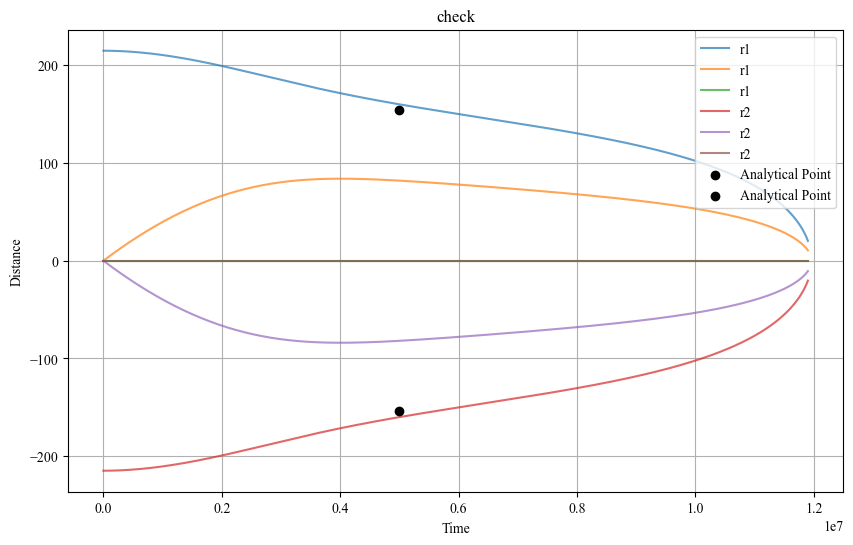

In [ ]:

plt.figure(figsize=(10, 6))
plt.plot(t_eval, r1_df_arr, label="r1", alpha=0.7)
plt.plot(t_eval, r2_df_arr, label="r2", alpha=0.7)

# Plot analytic point
plt.scatter(delta_t, r1[0], color='black', label='Analytical Point', zorder=5)
plt.scatter(delta_t, r2[0], color='black', label='Analytical Point', zorder=5)


plt.xlabel("Time")
plt.ylabel("Distance")
plt.title("check")
plt.legend()
plt.grid(True)
plt.show()

/var/folders/rf/799sdl_537nf32dnhw741jq80000gn/T/ipykernel_9467/2538031226.py:29: UserWarning: Attempting to set identical low and high zlims makes transformation singular; automatically expanding.
  ax.set_zlim([min(np.min(r1_sol[:, 2]), np.min(r2_sol[:, 2])), max(np.max(r1_sol[:, 2]), np.max(r2_sol[:, 2]))])


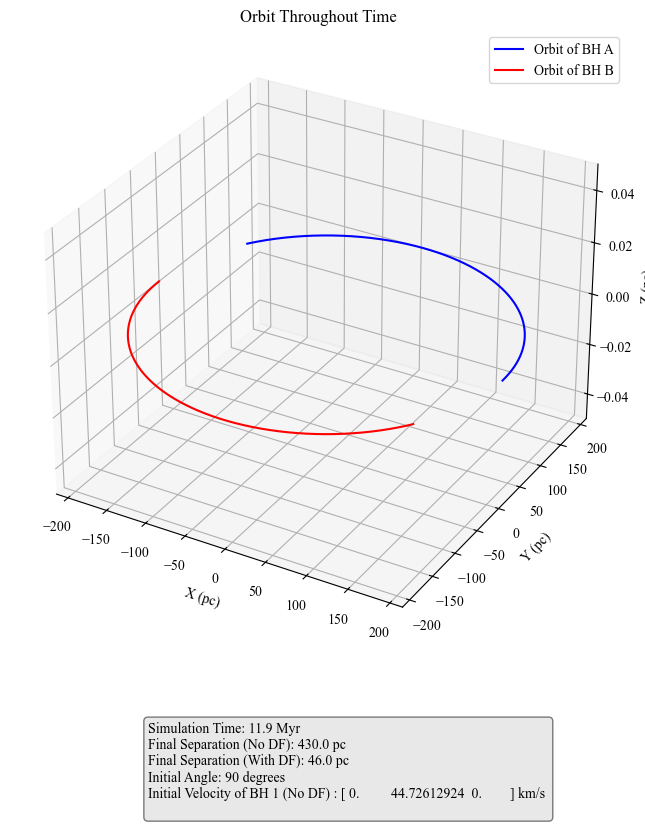

In [349]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation


fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

r1_sol = r1_nodf_arr
r2_sol = r2_nodf_arr
t = (data_dict_nodf['t'][-1] * u.yr).to(u.Myr)



ax.set_xlabel('X (pc)')
ax.set_ylabel('Y (pc)')
ax.set_zlabel('Z (pc)')
ax.set_title('Orbit Throughout Time')


line1, = ax.plot([], [], [], label="Orbit of BH A", color="blue")
line2, = ax.plot([], [], [], label="Orbit of BH B", color="red")
ax.legend()

# Limits for the plot (adjust as needed based on data)
ax.set_xlim([min(np.min(r1_sol[:, 0]), np.min(r2_sol[:, 0])), max(np.max(r1_sol[:, 0]), np.max(r2_sol[:, 0]))])
ax.set_ylim([min(np.min(r1_sol[:, 1]), np.min(r2_sol[:, 1])), max(np.max(r1_sol[:, 1]), np.max(r2_sol[:, 1]))])
ax.set_zlim([min(np.min(r1_sol[:, 2]), np.min(r2_sol[:, 2])), max(np.max(r1_sol[:, 2]), np.max(r2_sol[:, 2]))])


def update(num):

    line1.set_data(r1_sol[:num, 0], r1_sol[:num, 1])
    line1.set_3d_properties(r1_sol[:num, 2])
    
    line2.set_data(r2_sol[:num, 0], r2_sol[:num, 1])
    line2.set_3d_properties(r2_sol[:num, 2])
    
    return line1, line2

text_str = (
    f"Simulation Time: {t:.1f}\n"
    f"Final Separation (No DF): {np.linalg.norm(data_dict_nodf['r1'][-1]-data_dict_nodf['r2'][-1]):.1f} pc\n"
    f"Final Separation (With DF): {np.linalg.norm(data_dict_df['r1'][-1]-data_dict_df['r2'][-1]):.1f} pc\n"
    f"Initial Angle: {angle} degrees\n"
    # f"Initial Velocity of BH 1(No DF) : {data_dict_nodf['v1'][0]} km/s \n"
    f"Initial Velocity of BH 1 (No DF) : {data_dict_nodf['v1'][0]} km/s \n"
    )
# plt.text(0.02, 0.98, text_str, transform=plt.gca().transAxes,
#              verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
fig.text(0.3, -0.1, text_str, fontsize=10, bbox=dict(boxstyle="round", facecolor="lightgray", alpha=0.5))

ani = FuncAnimation(fig, update, frames=len(r1_sol), interval=50, blit=True)


# plt.show()


ani.save("functionsnodf.gif", writer="ffmpeg", fps=220)  # Adjust fps as needed